In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms, models
import os
from sklearn.metrics import f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
import random
from PIL import Image

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.cuda.empty_cache()


In [27]:
# Veri seti yolu
data_dir1 = "data1"
data_dir2 = "data2"
data_dir3 = "data3"

data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

https://youtube.com/ImageFolder(root=data_dir3, transform=data_transforms)

full_dataset = ConcatDataset([dataset_1, dataset_2,dataset_3])

split_ratio = 0.8
split_size = int(split_ratio * len(full_dataset))
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [split_size, len(full_dataset) - split_size])


In [28]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



/home/berkkucukk/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/berkkucukk/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
num_epochs = 1000
patience = 3
best_loss = float('inf')
counter = 0

train_loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    corrects_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        corrects_train += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss_list.append(epoch_loss)

    train_acc = corrects_train.double() / len(train_loader.dataset)
    train_acc_list.append(train_acc.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.4f}')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1} due to no improvement in loss.')
            break

model.eval()
corrects = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = corrects.double() / len(test_loader.dataset)
test_acc_list.append(test_acc.item())
print(f'Test Accuracy: {test_acc:.4f}')

f1 = f1_score(all_labels, all_preds, average='macro')  
mcc = matthews_corrcoef(all_labels, all_preds)

print(f'F1 Score: {f1:.4f}')
print(f'MCC: {mcc:.4f}')


Epoch 1/1000, Loss: 0.5723, Train Acc: 0.7690
Epoch 2/1000, Loss: 0.3617, Train Acc: 0.8650
Epoch 3/1000, Loss: 0.3125, Train Acc: 0.8782
Epoch 4/1000, Loss: 0.2621, Train Acc: 0.9038
Epoch 5/1000, Loss: 0.2455, Train Acc: 0.9094
Epoch 6/1000, Loss: 0.2005, Train Acc: 0.9300
Epoch 7/1000, Loss: 0.2033, Train Acc: 0.9234
Epoch 8/1000, Loss: 0.1725, Train Acc: 0.9424
Epoch 9/1000, Loss: 0.1608, Train Acc: 0.9422
Epoch 10/1000, Loss: 0.1574, Train Acc: 0.9438
Epoch 11/1000, Loss: 0.1584, Train Acc: 0.9430
Epoch 12/1000, Loss: 0.1361, Train Acc: 0.9503
Epoch 13/1000, Loss: 0.1428, Train Acc: 0.9503
Epoch 14/1000, Loss: 0.1202, Train Acc: 0.9558
Epoch 15/1000, Loss: 0.1197, Train Acc: 0.9556
Epoch 16/1000, Loss: 0.1106, Train Acc: 0.9595
Epoch 17/1000, Loss: 0.1310, Train Acc: 0.9513
Epoch 18/1000, Loss: 0.1029, Train Acc: 0.9639
Epoch 19/1000, Loss: 0.1244, Train Acc: 0.9519
Epoch 20/1000, Loss: 0.1009, Train Acc: 0.9651
Epoch 21/1000, Loss: 0.1104, Train Acc: 0.9622
Epoch 22/1000, Loss: 0

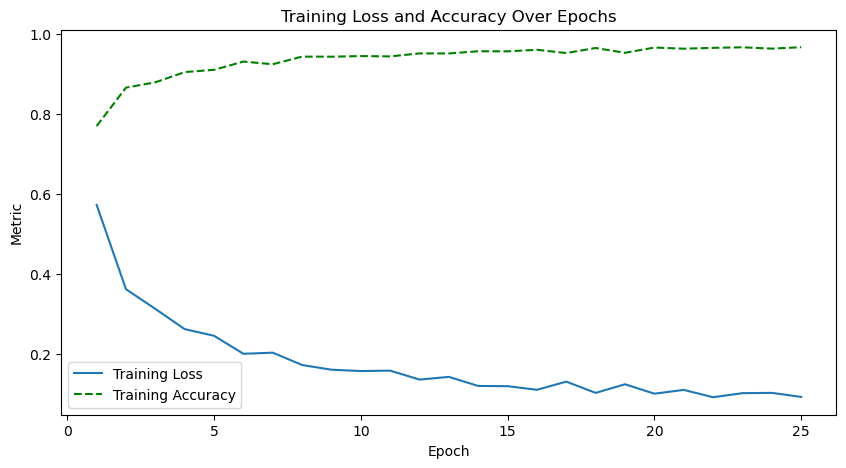

In [31]:
# Plotting the training loss and accuracy on the same plot
plt.figure(figsize=(10, 5))

# Plotting the training loss
plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting the training accuracy on the same plot
plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Training Accuracy', linestyle='--', color='green')
plt.ylabel('Metric')

plt.title('Training Loss and Accuracy Over Epochs')
plt.legend()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


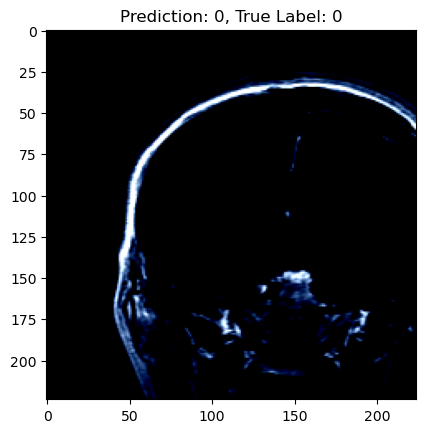

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


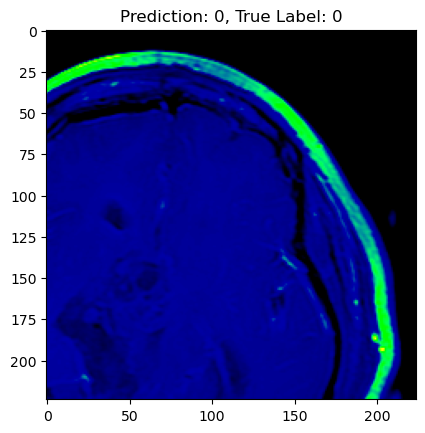

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


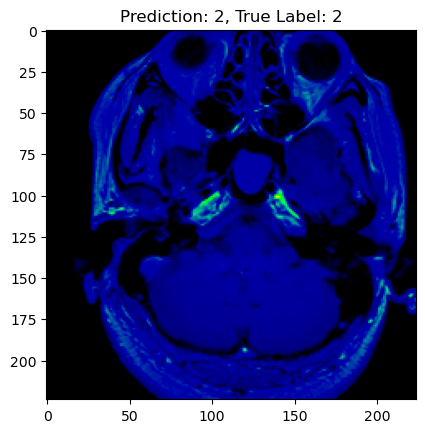

In [36]:
# Modelinizi eval moda çevirin
model.eval()

# Test veri kümesinden rasgele 3 örnek seçin
random_indices = random.sample(range(len(test_dataset)), 3)

# Seçilen örneklerin görsellerini ve etiketlerini alın
for idx in random_indices:
    image, label = test_dataset[idx]

    # Resmi tensor formatına dönüştürün
    input_image = image.unsqueeze(0).to(device)

    # Modeli kullanarak tahmin yapın
    with torch.no_grad():
        model_output = model(input_image)
        _, prediction = torch.max(model_output, 1)

    # Tahmin sonuçlarını ve gerçek etiketleri görsel olarak gösterin
    plt.imshow(image.permute(1, 2, 0))  # Resmi PIL formatına çevirerek göster
    plt.title(f"Prediction: {prediction.item()}, True Label: {label}")
    plt.show()
